In [1]:
#Importing libraries and setting seed
seed = 45871
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

# Load data + compute new columns

In [2]:
#Loading the data file
file_path = 'test data_ascending.xlsx'
df = pd.read_excel(file_path)

# Calculating log returns
df['Log_Returns'] = (np.log(df['Last Price']) - np.log(df['Last Price'].shift(1)))*100

# Calculate volatility on log returns 
window_size = 2  
df['std_dev'] = df['Log_Returns'].rolling(window=window_size).std()


# Display data frame
print(df.head())
print(df.tail())

        Date  Last Price  Log_Returns   std_dev
0 2005-04-22       16.85          NaN       NaN
1 2005-04-25       17.45     3.498899       NaN
2 2005-04-26       17.15    -1.734148  3.700323
3 2005-04-27       16.35    -4.777028  2.151641
4 2005-04-28       15.95    -2.476907  1.626431
           Date  Last Price  Log_Returns   std_dev
4873 2024-03-25       63.74     5.465136  0.982766
4874 2024-03-26       61.06    -4.295532  6.901835
4875 2024-03-27       61.21     0.245359  3.210895
4876 2024-03-28       60.58    -1.034577  0.905051
4877 2024-04-01       60.58     0.000000  0.731556


# Split data frame

In [3]:
start_date = '2008-04-03'
df = df[df['Date'] >= start_date]

print(df.head())
print(df.tail())

          Date  Last Price  Log_Returns   std_dev
755 2008-04-03       23.47     0.213265  2.620107
756 2008-04-04       23.31    -0.684056  0.634502
757 2008-04-07       23.82     2.164311  2.014099
758 2008-04-08       23.51    -1.309970  2.456688
759 2008-04-09       23.69     0.762716  1.465610
           Date  Last Price  Log_Returns   std_dev
4873 2024-03-25       63.74     5.465136  0.982766
4874 2024-03-26       61.06    -4.295532  6.901835
4875 2024-03-27       61.21     0.245359  3.210895
4876 2024-03-28       60.58    -1.034577  0.905051
4877 2024-04-01       60.58     0.000000  0.731556


In [4]:
# Split data frame into training data and test data
test_size = int(len(df) * 0.2)  
df_train = df[:-test_size]
df_test = df[-test_size:]

# Exclude NaN values from the date frames 
df_train = df_train.dropna()
df_test = df_test.dropna()

# Train model + predict observations

In [5]:
train, test = df.Log_Returns[:-test_size], df.Log_Returns[-test_size:]
model = arch_model(train, p=1, o=1, q=1, vol='egarch')
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 909027568115.8491
Iteration:      2,   Func. Count:     17,   Neg. LLF: 262585311603.88757
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2179993471898.189
Iteration:      4,   Func. Count:     37,   Neg. LLF: 717885783393.13
Iteration:      5,   Func. Count:     46,   Neg. LLF: 13263.892395428618
Iteration:      6,   Func. Count:     55,   Neg. LLF: 7919.384484372222
Iteration:      7,   Func. Count:     62,   Neg. LLF: 7918.829905947704
Iteration:      8,   Func. Count:     68,   Neg. LLF: 7918.828875688521
Iteration:      9,   Func. Count:     74,   Neg. LLF: 7918.828833049669
Iteration:     10,   Func. Count:     79,   Neg. LLF: 7918.828833044639
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7918.828833049669
            Iterations: 10
            Function evaluations: 79
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -7918.83
Distribution:                  Normal   AIC:                           15847.7
Method:            Maximum Likelihood   BIC:                           15878.2
                                        No. Observations:                 3299
Date:                Fri, May 17 2024   Df Residuals:                     3298
Time:                        23:08:56   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0783  4.007e-02      1.953  5.076e-02 [-2.593e-04,  0.157]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          0.0566  1.920e-02      2.950  3.174e-03   [1.901e-02,9.427e-02]
alpha[1]       0.2370  3.561e-02      6.657  2.803e-11       [  0.167,  0.307]
gamma[1]      -0.0372  1.637e-02     -2.270  2.323e-02 [-6.925e-02,-5.070e-03]
beta[1]        0.9771  9.477e-03    103.101      0.000       [  0.959,  0.996]
==============================================================================

Covariance estimator: robust
"""

In [6]:
predictions = []
for i in range(test_size):
    train = df.Log_Returns[:-(test_size-i)]
    model = arch_model(train, p=1, o=1, q=1, vol='egarch')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

predictions = pd.Series(predictions, index=df_test.index)
df_test['predictions'] = predictions

# Plot forecast results 

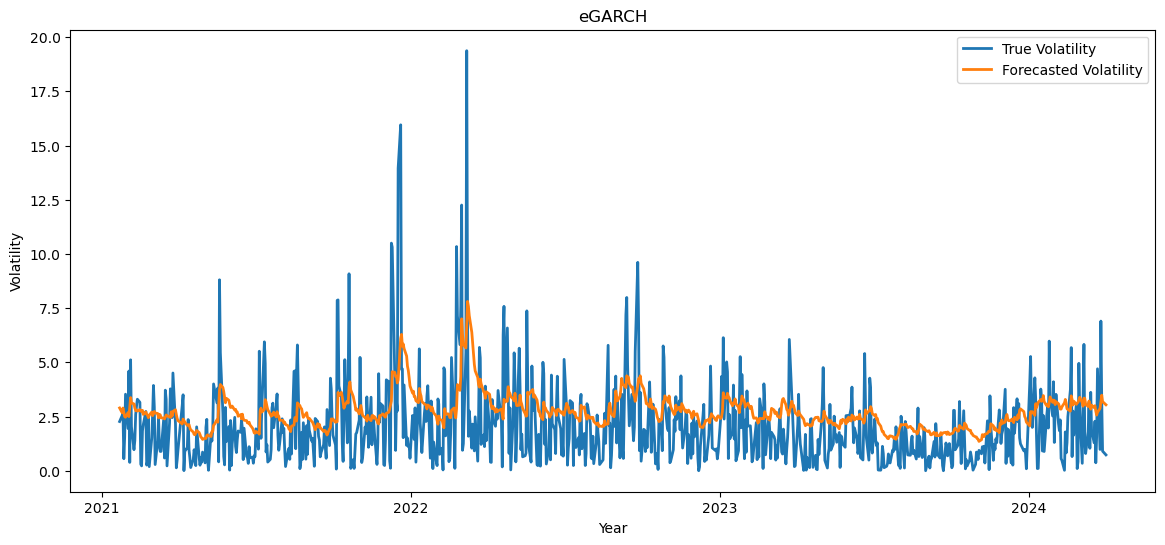

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot 'std_dev' and 'predictions'
ax.plot(df_test['Date'], df_test['std_dev'], label='True Volatility', linewidth=2)
ax.plot(df_test['Date'], df_test['predictions'], label='Forecasted Volatility', linewidth=2)

# Set the x-axis to show each year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# More layout 
plt.title('eGARCH')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.show()

plt.rcParams.update({'font.size': 20})

# Model evaluation 

In [8]:
# import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [9]:
# oos r^2 for entire test_size
r_squared = r2_score(df_test['std_dev'], predictions)
print("R-squared (R^2):", r_squared)

R-squared (R^2): 0.04458916565765958


In [10]:
# Horizon 1
df_test1 = df_test[:1]

# mse
mse1 = mean_squared_error(df_test1['std_dev'], df_test1['predictions'])
print('MSE_1', mse1)

# mae 
mae1 = mean_absolute_error(df_test1['std_dev'], df_test1['predictions'])
print('MAE_1', mae1)

# median absolute error
squared_errors1 = (df_test1['std_dev']-df_test1['predictions'])**2
median_squared_errors1 = np.median(squared_errors1)
print('MedSE_1', median_squared_errors1)

MSE_1 0.39182769054049155
MAE_1 0.625961412980458
MedSE_1 0.39182769054049155


In [11]:
# Horizon 5
df_test5 = df_test[:5]

# mse
mse5 = mean_squared_error(df_test5['std_dev'], df_test5['predictions'])
print('MSE_5', mse5)

# mae 
mae5 = mean_absolute_error(df_test5['std_dev'], df_test5['predictions'])
print('MAE_5', mae5)

# median absolute error
squared_errors5 = (df_test5['std_dev'] - df_test5['predictions'])**2
median_squared_errors5 = np.median(squared_errors5)
print('MedSE_5', median_squared_errors5)

MSE_5 1.1785569240367137
MAE_5 0.8134239197963193
MedSE_5 0.39182769054049155


In [12]:
# Horizon 10
df_test10 = df_test[:10]

# mse
mse10 = mean_squared_error(df_test10['std_dev'], df_test10['predictions'])
print('MSE_10', mse10)

# mae 
mae10 = mean_absolute_error(df_test10['std_dev'], df_test10['predictions'])
print('MAE_10', mae10)

# median absolute error
squared_errors10 = (df_test10['std_dev'] - df_test10['predictions'])**2
median_squared_errors10 = np.median(squared_errors10)
print('MedSE_10', median_squared_errors10)

MSE_10 2.1499233653086116
MAE_10 1.2256685125374813
MedSE_10 0.9989717111574062


In [13]:
# Horizon 15
df_test15 = df_test[:15]

# mse
mse15 = mean_squared_error(df_test15['std_dev'], df_test15['predictions'])
print('MSE_15', mse15)

# mae 
mae15 = mean_absolute_error(df_test15['std_dev'], df_test15['predictions'])
print('MAE_15', mae15)

# median absolute error
squared_errors15 = (df_test15['std_dev'] - df_test15['predictions'])**2
median_squared_errors15 = np.median(squared_errors15)
print('MedSE_15', median_squared_errors15)

MSE_15 1.9646642990746082
MAE_15 1.155630482266932
MedSE_15 1.1249458714093448


In [14]:
# Horizon 20
df_test20 = df_test[:20]

# mse
mse20 = mean_squared_error(df_test20['std_dev'], df_test20['predictions'])
print('MSE_20', mse20)

# mae 
mae20 = mean_absolute_error(df_test20['std_dev'], df_test20['predictions'])
print('MAE_20', mae20)

# median absolute error
squared_errors20 = (df_test20['std_dev'] - df_test20['predictions'])**2
median_squared_errors20 = np.median(squared_errors20)
print('MedSE_20', median_squared_errors20)

MSE_20 2.155640982987794
MAE_20 1.2063717669274099
MedSE_20 1.0071973395313976


In [15]:
# Horizon 25
df_test25 = df_test[:25]

# mse
mse25 = mean_squared_error(df_test25['std_dev'], df_test25['predictions'])
print('MSE_25', mse25)

# mae 
mae25 = mean_absolute_error(df_test25['std_dev'], df_test25['predictions'])
print('MAE_25', mae25)

# median absolute error
squared_errors25 = (df_test25['std_dev'] - df_test25['predictions'])**2
median_squared_errors25 = np.median(squared_errors25)
print('MedSE_25', median_squared_errors25)

MSE_25 2.135936471144065
MAE_25 1.1662649783341055
MedSE_25 0.8894488076534502


In [16]:
# Horizon 30
df_test30 = df_test[:30]

# mse
mse30 = mean_squared_error(df_test30['std_dev'], df_test30['predictions'])
print('MSE_30', mse30)

# mae 
mae30 = mean_absolute_error(df_test30['std_dev'], df_test30['predictions'])
print('MAE_30', mae30)

# median absolute error
squared_errors30 = (df_test30['std_dev'] - df_test30['predictions'])**2
median_squared_errors30 = np.median(squared_errors30)
print('MedSE_30', median_squared_errors30)

MSE_30 2.0729454657298385
MAE_30 1.1426310894931362
MedSE_30 1.0071973395313976


In [17]:
# Horizon 252
df_test252 = df_test[:252]

# mse
mse252 = mean_squared_error(df_test252['std_dev'], df_test252['predictions'])
print('MSE_252', mse252)

# mae 
mae252 = mean_absolute_error(df_test252['std_dev'], df_test252['predictions'])
print('MAE_252', mae252)

# median absolute error
squared_errors252 = (df_test252['std_dev'] - df_test252['predictions'])**2
median_squared_errors252 = np.median(squared_errors252)
print('MedSE_252', median_squared_errors252)

MSE_252 4.00975145127821
MAE_252 1.4924845975118943
MedSE_252 1.5789656546752462


In [18]:
# Horizon 2021
start_date2021 = '2021-01-22'
end_date2021 = '2021-12-31'

df_test2021 = df_test[(df_test['Date'] >= start_date2021) & (df_test['Date'] <= end_date2021)]

# mse
mse2021 = mean_squared_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MSE_2021', mse2021)

# mae 
mae2021 = mean_absolute_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MAE_2021', mae2021)

# median absolute error
squared_errors2021 = (df_test2021['std_dev'] - df_test2021['predictions'])**2
median_squared_errors2021 = np.median(squared_errors2021)
print('MedSE_2021', median_squared_errors2021)

MSE_2021 4.055881424166835
MAE_2021 1.4948085796165962
MedSE_2021 1.552357553849097


In [19]:
# Horizon 2022
start_date2022 = '2022-01-01'
end_date2022 = '2022-12-31'

df_test2022 = df_test[(df_test['Date'] >= start_date2022) & (df_test['Date'] <= end_date2022)]

# mse
mse2022 = mean_squared_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MSE_2022', mse2022)

# mae 
mae2022 = mean_absolute_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MAE_2022', mae2022)

# median absolute error
squared_errors2022 = (df_test2022['std_dev'] - df_test2022['predictions'])**2
median_squared_errors2022 = np.median(squared_errors2022)
print('MedSE_2022', median_squared_errors2022)

MSE_2022 4.801305311662617
MAE_2022 1.6958809452889247
MedSE_2022 2.474483317644011


In [20]:
# Horizon 2023
start_date2023 = '2023-01-01'
end_date2023 = '2023-12-31'

df_test2023 = df_test[(df_test['Date'] >= start_date2023) & (df_test['Date'] <= end_date2023)]

# mse
mse2023 = mean_squared_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MSE_2023', mse2023)

# mae 
mae2023 = mean_absolute_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MAE_2023', mae2023)

# median absolute error
squared_errors2023 = (df_test2023['std_dev'] - df_test2023['predictions'])**2
median_squared_errors2023 = np.median(squared_errors2023)
print('MedSE_2023', median_squared_errors2023)

MSE_2023 1.7683179293494287
MAE_2023 1.1269853293384156
MedSE_2023 1.1366514503914154


In [21]:
# Horizon 2024
start_date2024 = '2024-01-01'

df_test2024 = df_test[(df_test['Date'] >= start_date2024)]

# mse
mse2024 = mean_squared_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MSE_2024', mse2024)

# mae 
mae2024 = mean_absolute_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MAE_2024', mae2024)

# median absolute error
squared_errors2024 = (df_test2024['std_dev'] - df_test2024['predictions'])**2
median_squared_errors2024 = np.median(squared_errors2024)
print('MedSE_2024', median_squared_errors2024)

MSE_2024 3.128844858402769
MAE_2024 1.4742646544941673
MedSE_2024 2.3414474046536533


# summary of model evaluation

In [22]:
# MSE all horizons + R^2
print("R-squared (R^2):", r_squared)
print("MSE_1:", mse1)
print("MSE_5:", mse5)
print("MSE_10:", mse10)
print("MSE_15:", mse15)
print("MSE_20:", mse20)
print("MSE_25:", mse25)
print("MSE_30:", mse30)
print("MSE_252:", mse252)
print("MSE_2021:", mse2021)
print("MSE_2022:", mse2022)
print("MSE_2023:", mse2023)
print("MSE_2024:", mse2024)

R-squared (R^2): 0.04458916565765958
MSE_1: 0.39182769054049155
MSE_5: 1.1785569240367137
MSE_10: 2.1499233653086116
MSE_15: 1.9646642990746082
MSE_20: 2.155640982987794
MSE_25: 2.135936471144065
MSE_30: 2.0729454657298385
MSE_252: 4.00975145127821
MSE_2021: 4.055881424166835
MSE_2022: 4.801305311662617
MSE_2023: 1.7683179293494287
MSE_2024: 3.128844858402769


In [23]:
# MAE all horizons
print("MAE_1:", mae1)
print("MAE_5:", mae5)
print("MAE_10:", mae10)
print("MAE_15:", mae15)
print("MAE_20:", mae20)
print("MAE_25:", mae25)
print("MAE_30:", mae30)
print("MAE_252:", mae252)
print("MAE_2021:", mae2021)
print("MAE_2022:", mae2022)
print("MAE_2023:", mae2023)
print("MAE_2024:", mae2024)

MAE_1: 0.625961412980458
MAE_5: 0.8134239197963193
MAE_10: 1.2256685125374813
MAE_15: 1.155630482266932
MAE_20: 1.2063717669274099
MAE_25: 1.1662649783341055
MAE_30: 1.1426310894931362
MAE_252: 1.4924845975118943
MAE_2021: 1.4948085796165962
MAE_2022: 1.6958809452889247
MAE_2023: 1.1269853293384156
MAE_2024: 1.4742646544941673


In [24]:
# Median squared error
print("MedSE_1:", median_squared_errors1)
print("MedSE_5:", median_squared_errors5)
print("MedSE_10:", median_squared_errors10)
print("MedSE_15:", median_squared_errors15)
print("MedSE_20:", median_squared_errors20)
print("MedSE_25:", median_squared_errors25)
print("MedSE_30:", median_squared_errors30)
print("MedSE_252:", median_squared_errors252)
print("MedSE_2021:", median_squared_errors2021)
print("MedSE_2022:", median_squared_errors2022)
print("MedSE_2023:", median_squared_errors2023)
print("MedSE_2024:", median_squared_errors2024)

MedSE_1: 0.39182769054049155
MedSE_5: 0.39182769054049155
MedSE_10: 0.9989717111574062
MedSE_15: 1.1249458714093448
MedSE_20: 1.0071973395313976
MedSE_25: 0.8894488076534502
MedSE_30: 1.0071973395313976
MedSE_252: 1.5789656546752462
MedSE_2021: 1.552357553849097
MedSE_2022: 2.474483317644011
MedSE_2023: 1.1366514503914154
MedSE_2024: 2.3414474046536533
